# I: Preparing the data, packages and our AIF360 debiaser for implementation later. 

In [1]:
# installing the packages required
!pip install aif360

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Preparing the libraries and the function to generate the synthetic datasets

In [2]:
# importing the libraries
import pandas as pd
import random
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.stats as stats
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing import DisparateImpactRemover
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from sklearn.metrics import precision_score, recall_score, f1_score
from google.colab import drive
from aif360.algorithms.inprocessing import AdversarialDebiasing
from sklearn.preprocessing import StandardScaler
from aif360.algorithms.inprocessing import AdversarialDebiasing
import tensorflow.compat.v1 as tf
import pickle
from sklearn.linear_model import LogisticRegression
tf.disable_eager_execution()
plt.rcParams['figure.figsize'] = [12, 10]
# This function simulates x1 and x2 based on the probabilities of obtaining the attribute
def gen_random(p1, n =50):
  return(np.random.choice([0, 1], size=n, p=[1-p1, p1]))

# this function generates the datasets
def generate_datasets(p_A = 2/3, p_D = 1/3):
  # creating the data for group A - here they have a 2/3 probability of having attribute x1 and x2
    df_A=pd.DataFrame({"x1":gen_random(p_A), "x2":gen_random(p_A), "g":"A", "p":p_A})
    # creating the data for group A - here they have a 1/3 probability of having attribute x1 and x2
    df_D=pd.DataFrame({"x1":gen_random(p_D), "x2":gen_random(p_D), "g":"D","p":p_D})
    df_D["admitted"]=1
    df_A["admitted"]=1
    return [df_A, df_D]

# this function computes the admission metrics of our interest (ie equity and efficiency)
def compute_admit_metrics(df):
  df_admit = df[df["admitted"]==1]
  # selecting from group D
  n_admit_from_D=len(df_admit.loc[df_admit['g'] == "D"])
  # Selecting students from group A
  n_admit_from_A=len(df_admit.loc[df_admit['g'] == "A"])
  # Computing the fraction of people from group D admitted

  admit_frac_D = n_admit_from_D/len(df_admit)
  #print(df_admit['f'])
  #print(admit_frac_D)
  return (np.mean(df_admit['f']),admit_frac_D)

# this function computes our employment metrics
def compute_employ_metrics(df):
  df_emplyd = df[df["employed"]==1]
  # selecting from group D
  n_emplyd_from_D=len(df_emplyd.loc[df_emplyd['g'] == "D"])
  # Computing the fraction of people from group D admitted
  if len(df_emplyd)==0:
    print(df)
  emplyd_frac_D = n_emplyd_from_D/len(df_emplyd)

  return emplyd_frac_D

# here we mount our drive
drive.mount("/content/drive")
%cd '/content/drive/My Drive/Proj 1'


pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Proj 1


## defining the adveserial debiaser (to be used later as part of our AIF360 strategy)

In [3]:
# this function executes the pre-trained adverserial debiaser

def debias():
  # reading dataset
  data = pd.read_csv('biased_admit_dataset.csv')
  data=data[["x1", "x2","g",'p',"admitted"]]

  # converting to AIF360's dataset
  dataset = StandardDataset(data,protected_attribute_names=['g'],
      privileged_classes=[['A']], categorical_features=["x1","x2"],
      features_to_keep=['x1','x2'],label_name="admitted", favorable_classes=[1])

  # Get the dataset and split into train and test
  dataset_orig_train, dataset_orig_test = dataset.split([0.7], shuffle=True)
  # scale the binary features
  scale_orig = StandardScaler()
  dataset_orig_train.features = scale_orig.fit_transform(dataset_orig_train.features)
  dataset_orig_test.features = scale_orig.transform(dataset_orig_test.features)
  # Metric for the original dataset
  privileged_groups = [{'g': "A"}]
  unprivileged_groups = [{'g':"D"}]

  # definig the train and test
  metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)
  metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)


  # Create a TensorFlow session
  sess = tf.Session()

  # Train an adversarial debiasing model
  adversarial_debiasing = AdversarialDebiasing(unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups,
                                              scope_name='adversary',
                                              sess=sess,
                                              adversary_loss_weight=0.4,
                                              batch_size=256
                                              )
  adversarial_debiasing = adversarial_debiasing.fit(dataset_orig_train) # save this
  #dataset_transf_train = adversarial_debiasing.predict(dataset_orig_train)
  #dataset_transf_test = adversarial_debiasing.predict(dataset_orig_test)
  return(adversarial_debiasing)

# Transform training data and align features
adversarial_debiasing=debias()

# this function predicts transformed the bias dataset to unbias it
def debias_new_dataset(df): 
  new_dataset = StandardDataset(df,protected_attribute_names=['g'],
        privileged_classes=[['A']], categorical_features=["x1","x2"],
        features_to_keep=['x1','x2'],label_name="admitted",
        favorable_classes=[1])
  # new_dataset = df
  # print(new_dataset)
  new_dataset_transf = adversarial_debiasing.predict(new_dataset)
  return new_dataset_transf


/usr/local/lib/python3.9/dist-packages/aif360/metrics/utils.py:36: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  group_cond = np.logical_and(group_cond, X[:, index] == val)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 0.671365; batch adversarial loss: 0.756234
epoch 1; iter: 0; batch classifier loss: 0.603459; batch adversarial loss: 0.818564
epoch 2; iter: 0; batch classifier loss: 0.635299; batch adversarial loss: 0.837775
epoch 3; iter: 0; batch classifier loss: 0.739919; batch adversarial loss: 0.855101
epoch 4; iter: 0; batch classifier loss: 0.864359; batch adversarial loss: 0.848194
epoch 5; iter: 0; batch classifier loss: 1.026848; batch adversarial loss: 0.845362
epoch 6; iter: 0; batch classifier loss: 1.166021; batch adversarial loss: 0.838432
epoch 7; iter: 0; batch classifier loss: 1.117234; batch adversarial loss: 0.812426
epoch 8; iter: 0; batch classifier loss: 1.143537; batch adversarial loss: 0.803754
epoch 9; iter: 0; batch classifier loss: 1.008000; batch adversarial loss: 0.785039
epoch 10; iter: 0; batch classifier loss: 0.912981; batch adversarial loss: 0.762180
epoch 11; iter: 0; batch classifier loss: 1.000570; batch adversarial loss:

# II: Codes for criterias and simulations across a static generation. 

## this function computes our admissions based on each of our criterias, they include criterias 1 - 4, as well as affirmative action (denoted here as criteria 5) and our ML debiaser strategy (denoted as criteria 6) -- refer to the paper for more details 

In [4]:
# this function computes admit criteria 1

def admit_criteria_1(df, attributes=["f","x_sum"], n=50):
    n_admit = int(np.round((2*n)*(5/18),0))
    # reset the index
    df = df.sample(frac=1).reset_index(drop=True)
    # computing f, whereby if f is 0 or 1 and is 1 if it contains both x1 and x2
    df["f"] = df.apply(lambda row: int(row["x1"] and row["x2"]), axis = 1)
    # computing x_sum, because in some cases where f=0, we prefer to admit students who have either attributes x1 or x2, as opposed to having none at all
    df["x_sum"] = df.apply(lambda row: int(row["x1"] + row["x2"]), axis = 1)
    # sort the values and select the number of people of which we wish to admit
    df = (df.sort_values(by=attributes, ascending = False)).reset_index(drop=True)
    df_admit= df[0:n_admit]
    df_admit.loc[:,"admitted"] = 1
    df_not_admitted = df[n_admit:]
    df_not_admitted.loc[:,"admitted"] = 0
    df = pd.concat([df_admit,df_not_admitted])
    return df

# this function computes admit criteria 2
def admit_criteria_2(df, attributes=["x1"], n=50):
    n_admit = int(np.round((2*n)*(5/18),0))
    # reset the index
    df = df.sample(frac=1).reset_index(drop=True)
    # computing f, whereby if f is 0 or 1 and is 1 if it contains both x1 and x2
    df["f"] = df.apply(lambda row: int(row["x1"] and row["x2"]), axis = 1)
    # sort the values and select the number of people of which we wish to admit
    df = (df.sort_values(by=attributes, ascending = False)).reset_index(drop=True)
    df_admit= df[0:n_admit]
    df_admit.loc[:,"admitted"] = 1
    df_not_admitted = df[n_admit:]
    df_not_admitted.loc[:,"admitted"] = 0
    df = pd.concat([df_admit,df_not_admitted])
    return df


# This function simulates x1 and x2 based on the probabilities of obtaining the attribute
def gen_random(p1, n =50):
  return(np.random.choice([0, 1], size=n, p=[1-p1, p1]))

# Do not use x2, but use group membership information.
def admit_criteria_3(df, attributes=["x1"], n=50):
  # Create a new column 'est_f' and set its default value to 0
  df['est_f'] = 0
  # Set est_f to 2/3 when g is A and x1 is 1
  df.loc[(df['g'] == 'A') & (df['x1'] == 1), 'est_f'] = 2/3
  # Set est_f to 1/3 when g is D and x1 is 1
  df.loc[(df['g'] == 'D') & (df['x1'] == 1), 'est_f'] = 1/3
  deficit = n-len(df[df['est_f'] != 0])
  if deficit<=0:
    df=(df.sort_values(["est_f"],ascending = False)).reset_index(drop=True)
    df['admitted'] = 0
    df.loc[0:n, 'admitted'] = 1
    df_admit=df
  else:
    df['admitted'] = np.where(df['est_f'] > 0, 1, 0)
    df_unadmitted=(df[df["admitted"]==0]).reset_index(drop=True)
    df_admitted=df[df["admitted"]==1]
    df_unadmitted['est_x2'] = df_unadmitted.apply(lambda x: 2/3 if x['g'] == 'A' else 1/3, axis=1)
    df_unadmitted=(df_unadmitted.sort_values(["est_x2"],ascending = False)).reset_index(drop=True)
    df_unadmitted.loc[0:deficit, 'admitted'] = 1
    df_unadmitted = df_unadmitted.drop('est_x2', axis=1)
    df_admit=(pd.concat([df_admitted,df_unadmitted])).reset_index(drop=True)
  #display(df_admit)
  ad_admit=df_admit.drop("est_f",axis=1)
  df_admit["f"] = df_admit.apply(lambda row: int(row["x1"] and row["x2"]), axis = 1)
  return df_admit


# This function creates a table of students from groups A and D, with features x1 and x2 respectively, and output of f
def admit_criteria_4(df, attributes=["x1"], n=50):
  # collating the value of f
  df["f"] = df.apply(lambda row: int(row["x1"] and row["x2"]), axis = 1)

  # parsing by group category 
  df_A=df[df["g"]=="A"]
  df_D=df[df["g"]=="D"]
  # we know x2 for group D, so we know f, so if f=1 for group D we admit them, otherwise, we do not. 
  df_D_f_is_1 = df_D[df_D["f"]==1] 
  df_D_f_is_1['admitted'] = 1
  df_D_f_is_0 = df_D[df_D["f"]==0]

  # amongst the unadmitted we only know x1, so we collate them together and use x1 to admit them
  df_all_unadmitted = pd.concat([df_D_f_is_0, df_A])
  df_all_unadmitted= (df_all_unadmitted.sample(frac=1)).reset_index(drop=True)
  df_all_unadmitted=(df_all_unadmitted.sort_values(["x1"],ascending = False)).reset_index(drop=True)  
  # initialzing the admittted value to 0. 
  df_all_unadmitted['admitted'] = 0

  # whatever amount we did not admit from D previously, we now admit for the rest based on x1. 
  df_all_select_amount= n - len(df_D_f_is_1)
  df_all_unadmitted.loc[0:df_all_select_amount, 'admitted'] = 1

  df_admit_info=pd.concat([df_D_f_is_1,df_all_unadmitted])
  return(df_admit_info)

# this function computes our 'affirmative action' strategy
# This function creates a table of students from groups A and D, with features x1 and x2 respectively, and output of f
def admit_criteria_5(df, attributes=["f","x1","x2"], n=50):
  # collating the value of f
  df["f"] = df.apply(lambda row: int(row["x1"] and row["x2"]), axis = 1)
  admit_size_per_group=int(n/2)
  # parsing by group category and admitting the same number of students from each group 
  df_A=df[df["g"]=="A"]
  df_A=(df_A.sort_values(attributes,ascending = False)).reset_index(drop=True)
  df_A['admitted'] = 0
  df_A.loc[0:admit_size_per_group, 'admitted'] = 1
  df_D=df[df["g"]=="D"]
  df_D=(df_D.sort_values(attributes,ascending = False)).reset_index(drop=True)
  df_D['admitted'] = 0
  df_D.loc[0:admit_size_per_group, 'admitted'] = 1  
  df_admit_info=pd.concat([df_A,df_D])
  return(df_admit_info)

# this function computes our ML debiasing strategy
def admit_criteria_6(df, attributes=["f","x1","x2"], n=50):

  # getting our pre-trained logisitic regression. 
  with open('logistic_regression_model.pkl', 'rb') as f: #reading logistic regression classifier
    lr_transf = pickle.load(f)
  #df = df.sort_index()
  # print("Initial",df.shape)
  
  # debiasing our dataset. 
  new_dataset = debias_new_dataset(df)

  # using the pre-trained logistic regression to predict our admissions. 
  # print(admit_criteria_1(df))
  y_pred = lr_transf.predict(new_dataset.features)  # getting predictions
  score_function_values=lr_transf.decision_function(new_dataset.features) # getting score__function_values
  # print(new_dataset)
  df_new, y=(new_dataset.convert_to_dataframe()) # converting to pandas dataframe # comment out later
  df_new.rename(columns = {'x1=1':'x1', 'x2=1':'x2'}, inplace = True) # comment out later 
  # df_new = df #comment out later
  #print(df_new)
  df_new["score_function_values"]=list(score_function_values) # putting them in a dataframe
  df_new = (df_new.sample(frac=1)).reset_index()
  
  df_new['index'] = df_new['index'].astype(int)
  df = df.drop("admitted",axis=1)
  # print(df_new["index"].value_counts())
  df_new = (pd.merge(df, df_new[['index', 'score_function_values',"admitted"]], left_index=True, right_on='index', how='left')).reset_index()
  # print("Mid",df_new.shape)
  df_new = (df_new.sample(frac=1)).reset_index(drop=True)
  # print("Post",df_new.shape)
  df_new = (df_new.sort_values(["score_function_values"], ascending=False))
  df_new=df_new.reset_index(drop=True)
  df_new=df_new.drop(["level_0","score_function_values","index"],axis=1)
  df_new['admitted'] = 0
  df_new.loc[0:n-1, 'admitted'] = 1

  df_new["f"] = df_new.apply(lambda row: int(row["x1"] and row["x2"]), axis = 1)
  df_new['g'] = df_new['g'].replace({1: 'A', 0: 'D'})
  
  
  return df_new

# This function creates a table of students from groups A and D, with features x1 and x2 respectively, and output of f
def evaluation(attributes, func):
  # define the number of students from each group (A and D)
  n = 50
  admit_frac_D,avg_f = [], []
  for i in tqdm(range(0,1000)):
    # combining the data for group A and D respectively. 
    df=pd.concat(generate_datasets(p_A = 2/3, p_D = 1/3)).reset_index(drop=True)
    # defining the number of students we wish to admit 
    df = func(df, attributes=attributes, n= n)
    df["f"] = df.apply(lambda row: int(row["x1"] and row["x2"]), axis = 1)
    mean_f, frac_D = compute_admit_metrics(df)
    admit_frac_D.append(frac_D)
    # computing the average f of admitted students
    avg_f.append(mean_f)

  return (admit_frac_D,avg_f)

# this function makes the plots of the admitted rate group for D and average f. 
def plots(admit_frac_D,avg_f):
  sns.kdeplot(admit_frac_D, label="Admitted rate for group D")
  sns.kdeplot(avg_f, label="Average f")
  plt.title('Density plot of admitted rate from group D and average f value for 1000 simulations')
  plt.xlabel('Rate')
  plt.legend()

In [ ]:
### FOR TESTING REASONS -- PLEASE IGNORE ### 
# df = pd.concat(generate_datasets(p_A = 2/3, p_D = 1/3)).reset_index(drop=True)
# # # df["p"]=0.3
# df= admit_criteria_6(df)
# compute_admit_metrics(df)
# df

# df = pd.concat(generate_datasets(p_A = 2/3, p_D = 1/3)).reset_index(drop=True)
# df= admit_criteria_3(df)
# df
# compute_admit_metrics(df)

## Now that we have the function that defines and computes all our criterias, we need a function to simulate them. 

In [5]:
# simulating criterias 1 - 6. 

#criteria 1: use f (and then either x1 or x2 if f=0)
admit_frac_D1, avg_f1= evaluation(["f","x_sum"], func = admit_criteria_1)

# criteria 2: use x1
admit_frac_D2, avg_f2= evaluation(["x1"], func = admit_criteria_2)
# criteria 3
admit_frac_D3,avg_f3=evaluation(None, func = admit_criteria_3)
#criteria 4
admit_frac_D4, avg_f4= evaluation(None, func = admit_criteria_4)

# criteria 5
admit_frac_D5, avg_f5= evaluation(["f","x1","x2"], func = admit_criteria_5) # Equal distributions per group 

# # criteria 6
admit_frac_D6, avg_f6= evaluation(["f","x1","x2"], func = admit_criteria_6) # ML fairness


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-4-99307402a2ae>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_D_f_is_1['admitted'] = 1
  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegression fro

## compute the mean and standard deviation for each simulation

In [6]:
# computing the mean and standard deviation for each simulation

def compute_mean_and_sd(admit_frac,avg_f):
  return("Admit % D Mean: {}, sd {} --- Avg f mean: {}, sd {}".format(np.mean(admit_frac),np.std(admit_frac),np.mean(avg_f),np.std(avg_f)))

admit_frac,avg_f=[admit_frac_D1,admit_frac_D2,admit_frac_D3,admit_frac_D4,admit_frac_D5,admit_frac_D6],[avg_f1,avg_f2,avg_f3,avg_f4,avg_f5,avg_f6]
for i in range(len(admit_frac)):
  print("criteria", i+1, compute_mean_and_sd(admit_frac[i],avg_f[i]))

criteria 1 Admit % D Mean: 0.21785714285714286, sd 0.06780072842905306 --- Avg f mean: 0.9391785714285714, sd 0.08522771867539483
criteria 2 Admit % D Mean: 0.3324642857142857, sd 0.07856752425364401 --- Avg f mean: 0.5563214285714286, sd 0.09325512925653506
criteria 3 Admit % D Mean: 0.30066666666666664, sd 0.053921368983587625 --- Avg f mean: 0.5398823529411765, sd 0.07695883349594454
criteria 4 Admit % D Mean: 0.3455098039215686, sd 0.04913460628512566 --- Avg f mean: 0.5317058823529413, sd 0.07392263742921096
criteria 5 Admit % D Mean: 0.5, sd 0.0 --- Avg f mean: 0.5294807692307693, sd 0.0734074282191624
criteria 6 Admit % D Mean: 0.59768, sd 0.059182916453990334 --- Avg f mean: 0.51268, sd 0.06728460150732855


## plot the simulations. 

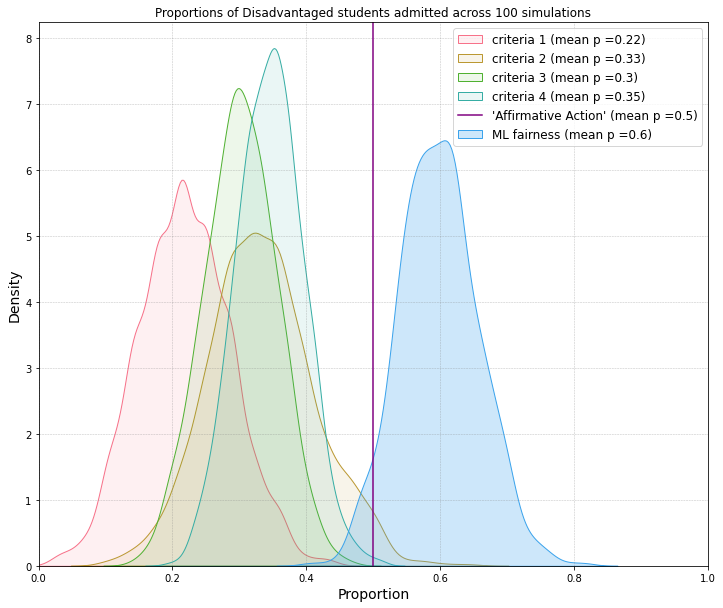

In [7]:
# here we plot the simulations for equity -- defined as the percent of disadvantaged students who get admitted.

colors = sns.color_palette('husl', n_colors=6
)
alpha=0.1
sns.set_palette(sns.color_palette(colors))
sns.kdeplot(admit_frac_D1, fill=True, label=f"criteria 1 (mean p ={np.round(np.mean(admit_frac_D1),2)})", alpha=alpha)
sns.kdeplot(admit_frac_D2, fill=True, label=f"criteria 2 (mean p ={np.round(np.mean(admit_frac_D2),2)})",alpha=alpha)
sns.kdeplot(admit_frac_D3,fill=True, label=f"criteria 3 (mean p ={np.round(np.mean(admit_frac_D3),2)})",alpha=alpha)
sns.kdeplot(admit_frac_D4, fill=True, label=f"criteria 4 (mean p ={np.round(np.mean(admit_frac_D4),2)})",alpha=alpha)
plt.axvline(admit_frac_D5[0],  label=f"'Affirmative Action' (mean p ={np.round(np.mean(admit_frac_D5),2)})", color="purple")

sns.kdeplot(admit_frac_D6, fill=True, label=f"ML fairness (mean p ={np.round(np.mean(admit_frac_D6),2)})")
plt.legend(fontsize = 12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.title("Proportions of Disadvantaged students admitted across 100 simulations", fontsize=12)
plt.xlabel("Proportion", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim([0,1])
plt.show()

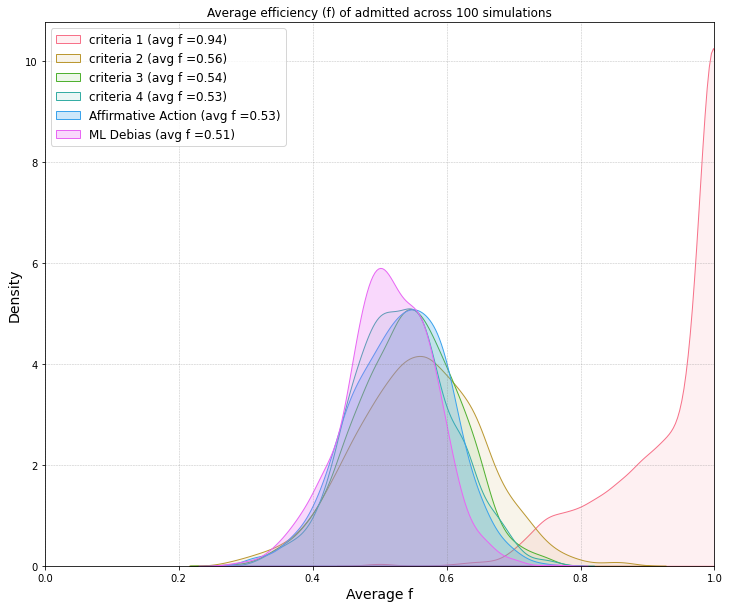

In [8]:
# here we plot the simulations for equity -- defined as the average f-score
colors = sns.color_palette('husl', n_colors=6)
alpha=0.1
sns.set_palette(sns.color_palette(colors))
sns.kdeplot(avg_f1, fill=True, label=f"criteria 1 (avg f ={np.round(np.mean(avg_f1),2)})",alpha=alpha)
sns.kdeplot(avg_f2, fill=True, label=f"criteria 2 (avg f ={np.round(np.mean(avg_f2),2)})",alpha=alpha)
sns.kdeplot(avg_f3,fill=True, label=f"criteria 3 (avg f ={np.round(np.mean(avg_f3),2)})",alpha=alpha)
sns.kdeplot(avg_f4, fill=True, label=f"criteria 4 (avg f ={np.round(np.mean(avg_f4),2)})",alpha=alpha)
sns.kdeplot(avg_f5, fill=True, label=f"Affirmative Action (avg f ={np.round(np.mean(avg_f5),2)})")
sns.kdeplot(avg_f6, fill=True, label=f"ML Debias (avg f ={np.round(np.mean(avg_f6),2)})")
plt.legend(loc ="upper left",fontsize = 12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.title("Average efficiency (f) of admitted across 100 simulations", fontsize=12)
plt.xlabel("Average f", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim([0,1])
plt.show()

# III: Here we start making the simulations across 100 generations. 

## We start of by defining our growth function that will be used to measure the outcomes across distinct generations. 

In [9]:
# this function computes the growth function
def growth_func(generation,a,b,epsilon):
  if generation>0:
    growth=100*(a**(b+generation))+epsilon
  else:
    growth=0
  return(growth/100)

# this function takes your parents p (prob of going to college, and then computes your p, based on the growth function)
def your_p(group,parents_p,generation, par_went_col = 0):
  # if parents went to college, you have a greater advantage of going to college, it is a growth function 
  if par_went_col ==1:
    epsilon=0.01
    if group=="A":
      a,b=0.8,12
    elif group=="D":
      a,b=0.9,20
    new_p=min(0.75,parents_p*(1+growth_func(generation,a,b,epsilon)))
    return new_p
  # else it is a devay function
  else:
    return 0.9975*parents_p

# getting the list of p for a 
list_of_p_for_a=[0.33]
for i in range(1,100):
  list_of_p_for_a.append(your_p("D",list_of_p_for_a[-1],i,par_went_col=1))


## here we prepare the code needed to perform and execute the simulations. 

In [10]:
# now that we define the growth function, here we simulate the changes across all generations. 

def simulation(criteria, n_gens=100):
  p_a = 2/3
  p_d = 1/3
  df_A=pd.DataFrame({"x1":gen_random(2/3), "x2":gen_random(2/3), "g":"A","admitted":0,"p":p_a, "t":0})
  # creating the data for group A - here they have a 1/3 probability of having attribute x1 and x2
  df_D=pd.DataFrame({"x1":gen_random(1/3), "x2":gen_random(1/3), "g":"D","admitted":0,"p":p_d, "t":0})
  # combining the data for group A and D respectively. 
  df=pd.concat([df_A,df_D]).reset_index(drop=True)
  mean_f, equity =[],[]
  datasets = []
  for i in tqdm(range(1, n_gens+1)):
    # print("Shap1",df.shape)
    df = admit_students(df,criteria).reset_index(drop=True)
    datasets.append(df.copy())
    # print("Shap2",df.shape)
    # compute average f and proportion
    metrics = compute_admit_metrics(df)
    mean_f.append(metrics[0])
    equity.append(metrics[1])
    # recompute the p for the next generation
    df["p"]= df.apply(lambda row: your_p(row["g"],row["p"],row["t"]+1, par_went_col=row["admitted"]),axis=1)
    
    df["t"]= df.apply(lambda row:row["t"]+1,axis=1)
    #print(i,":",df["f"].sum())
    #print(i, ":", df["p"].sum())
    df.loc[:,"admitted"]= 0
    df["x1"]= df.apply(lambda row: gen_random(row["p"])[0],axis=1)
    df["x2"]= df.apply(lambda row: gen_random(row["p"])[0],axis=1)
    
  return(mean_f, equity,datasets)

# this function allows us to simply input the datset and the criteria and provides us with the admissions for each group. 

def admit_students(df, criteria=1):
  # admit logic and change admitted to 1 if admitted
  if criteria==1:
    returned=admit_criteria_1(df)
  elif criteria==2:
    returned=admit_criteria_2(df)
  elif criteria==3:
    returned=admit_criteria_3(df)
  elif criteria==4:
    returned=admit_criteria_4(df)
  elif criteria==5:
    returned=admit_criteria_5(df)
  elif criteria==6:
    returned=admit_criteria_6(df)
  else:
    returned="Invalid"
  return (returned)



In [11]:
#generate biased admissions datasets over 100 generations
dataset= pd.concat(simulation(criteria=1, n_gens=100)[2])
dataset.to_csv("./biased_admit_dataset.csv",index=False)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
100%|██████████| 100/100 [00:03<00:00, 30.16it/s]


In [12]:
# this function here executes the generational simulations for each criteria and stores them in a list. 

criteria_1_f =[]
criteria_1_eq =[]
criteria_2_f =[]
criteria_2_eq =[]
criteria_3_f =[]
criteria_3_eq =[]
criteria_4_f =[]
criteria_4_eq =[]
criteria_5_f =[]
criteria_5_eq =[]
criteria_6_f =[]
criteria_6_eq =[]
for i in range(10):
  sim1 = simulation(1)
  sim2 = simulation(2)
  sim3 = simulation(3)
  sim4 = simulation(4)
  sim5 = simulation(5)
  sim6 = simulation(6)
  criteria_1_f.append(sim1[0])
  criteria_1_eq.append(sim1[1])
  criteria_2_f.append(sim2[0])
  criteria_2_eq.append(sim2[1])
  criteria_3_f.append(sim3[0])
  criteria_3_eq.append(sim3[1])
  criteria_4_f.append(sim4[0])
  criteria_4_eq.append(sim4[1])
  criteria_5_f.append(sim5[0])
  criteria_5_eq.append(sim5[1])
  criteria_6_f.append(sim6[0])
  criteria_6_eq.append(sim6[1])


# plots_generations([,simulation(2),simulation(3),simulation(4),simulation(5)],"mean_f")


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-4-99307402a2ae>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_D_f_is_1['admitted'] = 1
  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.2.1. This might lead to bre

## now that we have defined the code needed to simulate the admissions across generations, we can plot them here. 

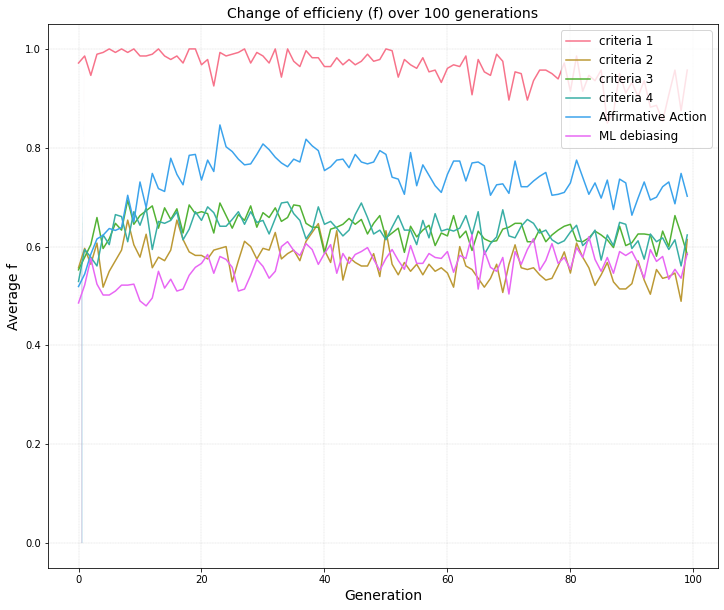

In [13]:

# plotting efficiency across generations
colors = sns.color_palette('husl', n_colors=5)
alpha = 0.99
mean = np.mean(criteria_1_f, axis=0)
sem = stats.sem(criteria_1_f, axis=0)
plt.plot(mean, label=f'criteria 1',alpha=alpha)
plt.fill_between(mean - sem, mean + sem, alpha=0.1)

mean = np.mean(criteria_2_f, axis=0)
sem = stats.sem(criteria_2_f, axis=0)
plt.plot(mean, label=f'criteria 2',alpha=alpha)
plt.fill_between(mean - sem, mean + sem, alpha=0.2)

mean = np.mean(criteria_3_f, axis=0)
sem = stats.sem(criteria_3_f, axis=0)
plt.plot(mean, label=f'criteria 3',alpha=alpha)
plt.fill_between(mean - sem, mean + sem, alpha=0.2)

mean = np.mean(criteria_4_f, axis=0)
sem = stats.sem(criteria_4_f, axis=0)
plt.plot(mean, label=f'criteria 4',alpha=alpha)
plt.fill_between(mean - sem, mean + sem, alpha=0.2)

mean = np.mean(criteria_5_f, axis=0)
sem = stats.sem(criteria_5_f, axis=0)
plt.plot(mean, label=f'Affirmative Action')
plt.fill_between(mean - sem, mean + sem, alpha=0.2)

mean = np.mean(criteria_6_f, axis=0)
sem = stats.sem(criteria_6_f, axis=0)
plt.plot(mean, label=f'ML debiasing')
plt.fill_between(mean - sem, mean + sem, alpha=0.2)


plt.grid(color='gray', linestyle='--', linewidth=0.3, alpha=0.5)
plt.title("Change of efficieny (f) over 100 generations", fontsize=14)
plt.xlabel("Generation", fontsize=14)
plt.ylabel("Average f", fontsize=14)
plt.legend(loc ="upper right",fontsize = 12)
plt.show()

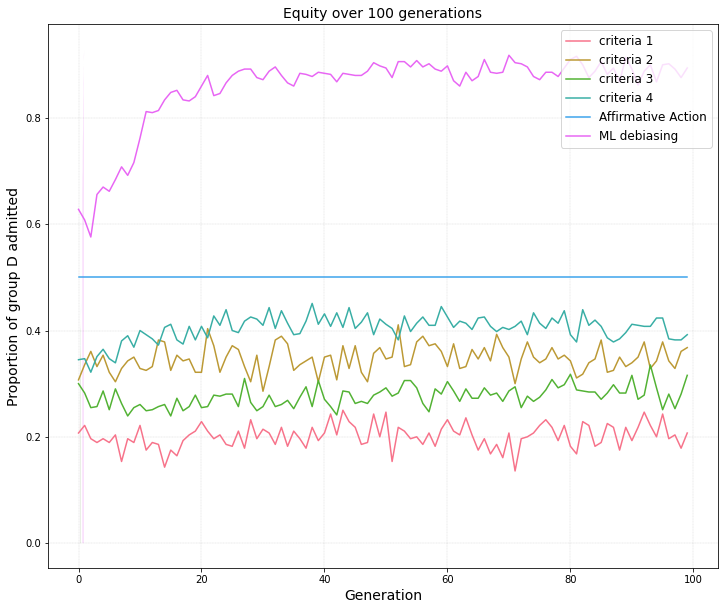

In [14]:
# plotting average f across generations. 

colors = sns.color_palette('husl', n_colors=5)
alpha = 0.99
mean = np.mean(criteria_1_eq, axis=0)
sem = stats.sem(criteria_1_eq, axis=0)
plt.plot(mean, label=f'criteria 1',alpha=alpha)
plt.fill_between(mean - sem, mean + sem, alpha=0.2)

mean = np.mean(criteria_2_eq, axis=0)
sem = stats.sem(criteria_2_eq, axis=0)
plt.plot(mean, label=f'criteria 2',alpha=alpha)
plt.fill_between(mean - sem, mean + sem, alpha=0.2)

mean = np.mean(criteria_3_eq, axis=0)
sem = stats.sem(criteria_3_eq, axis=0)
plt.plot(mean, label=f'criteria 3',alpha=alpha)
plt.fill_between(mean - sem, mean + sem, alpha=0.2)

mean = np.mean(criteria_4_eq, axis=0)
sem = stats.sem(criteria_4_eq, axis=0)
plt.plot(mean, label=f'criteria 4',alpha=alpha)
plt.fill_between(mean - sem, mean + sem, alpha=0.2)

mean = np.mean(criteria_5_eq, axis=0)
sem = stats.sem(criteria_5_eq, axis=0)
plt.plot(mean, label=f'Affirmative Action')
plt.fill_between(mean - sem, mean + sem, alpha=0.2)


mean = np.mean(criteria_6_eq, axis=0)
sem = stats.sem(criteria_6_eq, axis=0)
plt.plot(mean, label=f'ML debiasing')
plt.fill_between(mean - sem, mean + sem, alpha=0.2)

plt.grid(color='gray', linestyle='--', linewidth=0.3, alpha=0.5)
plt.title("Equity over 100 generations", fontsize=14)
plt.xlabel("Generation", fontsize=14)
plt.ylabel("Proportion of group D admitted", fontsize=14)
plt.legend(loc ="upper right",fontsize = 12)
plt.show()

# PART IV: here we consider the employments acrosss a static generation and 100 generations

In [15]:
# defining our employment probabilities.
empt_probs = {
    "11A1":  0.99,
    "11D1":  0.85,
    "11A0": 0.67,
    "11D0": 0.45,
    "10A1": 0.95,
    "10D1": 0.79,
    "10A0": 0.55,
    "10D0": 0.35,
    "01A1": 0.95,
    "01D1": 0.79,
    "01A0": 0.55,
    "01D0": 0.35,
    "00A1": 0.85,
    "00D1": 0.76,
    "00A0": 0.5,
    "00D0": 0.34
}



## Here we simualte employment for a static generation. 

In [ ]:
# here we simulate empployment
def simulate_employment(df, n=80):

  # df["employed"] = df.apply(lambda row: gen_random(empt_probs[f"{row['x1']}{row['x2']}{row['g']}{row['admitted']}"],n=1)[0], axis =1)
  # df = df.sort_values(by="employed", ascending = False)

  # df.loc[0:n, "employed"] = 1
  
  # df.loc[n:len(df)-1, "employed"] = 0
  # print( df["employed"].sum())

  # generate random "employed" variable based on probabilities
  prob_dict = {}
  for index, row in df.iterrows():
      key = f"{row['x1']}{row['x2']}{row['g']}{row['admitted']}"
      prob_dict[index] = gen_random(empt_probs[key], n=1)[0]
  df["employed"] = pd.Series(prob_dict)

  # set top n values of "employed" to 1 and the rest to 0

  df.loc[df["employed"].nlargest(n).index, "employed"] = 1
  df.loc[df["employed"].nsmallest(len(df)-n).index, "employed"] = 0

  # print total number of people employed
  # print(df["employed"].sum())

  return df


# executing / implementing our simulate empolyment
p_a = 2/3
p_d = 1/3
frac_criterians =[[],[],[],[],[],[]]
for _ in tqdm(range(100)):
  df_A=pd.DataFrame({"x1":gen_random(2/3), "x2":gen_random(2/3), "g":"A","admitted":0,"p":p_a, "t":0})
  # creating the data for group A - here they have a 1/3 probability of having attribute x1 and x2
  df_D=pd.DataFrame({"x1":gen_random(1/3), "x2":gen_random(1/3), "g":"D","admitted":0,"p":p_d, "t":0})
  # combining the data for group A and D respectively. 
  df=pd.concat([df_A,df_D]).reset_index(drop=True)
  df = df.sample(frac=1)
  for i in range(0,6): 
    df_a = admit_students(df,i+1).reset_index(drop=True)
    df_a = simulate_employment(df_a)
    frac_D_emplyd = compute_employ_metrics(df_a)
    frac_criterians[i].append(frac_D_emplyd)

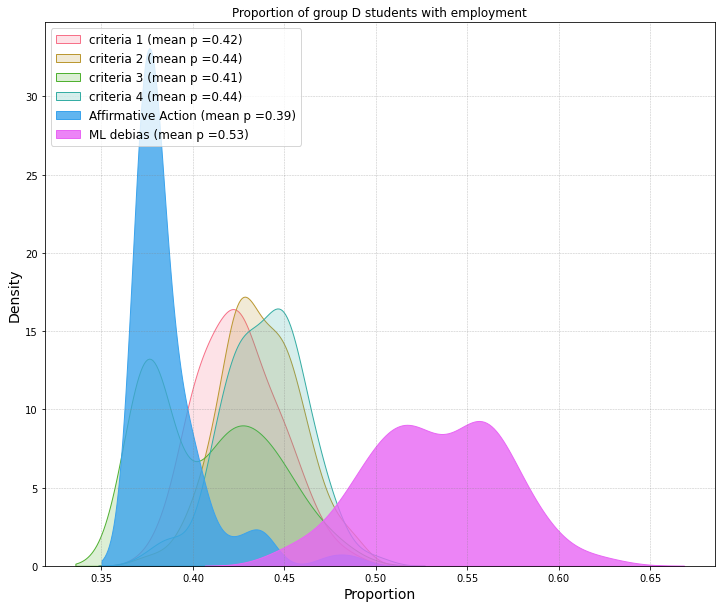

In [17]:
# plotting the graphs for employment of one generation
colors = sns.color_palette('husl', n_colors=6)
sns.set_palette(sns.color_palette(colors))
alpha = 0.2
for i in range(0,4):
  sns.kdeplot(frac_criterians[i], fill=True, label=f"criteria {i+1} (mean p ={np.round(np.mean(frac_criterians[i]),2)})",alpha = alpha)
sns.kdeplot(frac_criterians[4], fill=True, label=f"Affirmative Action (mean p ={np.round(np.mean(frac_criterians[4]),2)})",alpha=0.8)
sns.kdeplot(frac_criterians[5], fill=True, label=f"ML debias (mean p ={np.round(np.mean(frac_criterians[5]),2)})",alpha=0.8)
plt.legend(fontsize = 12, loc ="upper left")
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.title("Proportion of group D students with employment", fontsize=12)
plt.xlabel("Proportion", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.show()

In [18]:
# computing mean and standard deviation. 
def compute_mean_and_sd(list_of_employment):
  return("Employment Mean: {}, sd {}".format(np.mean(list_of_employment),np.std(list_of_employment)))
list_of_employment=[frac_criterians[i] for i in range(0,6)]
for i in list_of_employment:
  print(compute_mean_and_sd(i))

Employment Mean: 0.425, sd 0.022290693125158762
Employment Mean: 0.43674999999999997, sd 0.021781586259958206
Employment Mean: 0.40837500000000004, sd 0.032694370692827227
Employment Mean: 0.439125, sd 0.022336559157578418
Employment Mean: 0.38612500000000005, sd 0.020758657832335884
Employment Mean: 0.5335, sd 0.036266375611577174


## Here we simulate employment for over 100 generations. 

In [39]:
# preparing simulation for 100 generations
def simulate_employment_evolution(criteria, n_gens=100):
  p_a = 2/3
  p_d = 1/3
  df_A=pd.DataFrame({"x1":gen_random(2/3), "x2":gen_random(2/3), "g":"A","admitted":0,"p":p_a, "t":0})
  # creating the data for group A - here they have a 1/3 probability of having attribute x1 and x2
  df_D=pd.DataFrame({"x1":gen_random(1/3), "x2":gen_random(1/3), "g":"D","admitted":0,"p":p_d, "t":0})
  # combining the data for group A and D respectively. 
  df=(pd.concat([df_A,df_D])).reset_index(drop=True)
  df = df.sample(frac=1)
  equity =[]
  for i in tqdm(range(1, n_gens+1)):
    df = admit_students(df,criteria).reset_index(drop=True)
    df = simulate_employment(df)
    # print(i,df["employed"].sum())
    frac_D_emplyd = compute_employ_metrics(df)
    equity.append(frac_D_emplyd)
    # recompute the p for the next generation
    df["p"]= df.apply(lambda row: your_p(row["g"],row["p"],row["t"]+1, par_went_col=row["admitted"]),axis=1)
    df["t"]= df.apply(lambda row:row["t"]+1,axis=1)
    df.loc[:,"admitted"]= 0
    df["x1"]= df.apply(lambda row: gen_random(row["p"])[0],axis=1)
    df["x2"]= df.apply(lambda row: gen_random(row["p"])[0],axis=1)
  return equity

# exeecuting the simulations
frac_criterians_ev =[[],[],[],[],[],[]]
for i in tqdm(range(0,6)):
  sim_criteria_ev = []
  for j in range(10):
    frac_D_emplyd = simulate_employment_evolution(criteria=(int(i)+1))
    sim_criteria_ev.append(frac_D_emplyd)
  frac_criterians_ev[i].append(sim_criteria_ev)
print(frac_criterians_ev)

Streaming output truncated to the last 5000 lines.
100%|██████████| 100/100 [00:04<00:00, 20.70it/s]

100%|██████████| 100/100 [00:06<00:00, 15.17it/s]

100%|██████████| 100/100 [00:04<00:00, 20.93it/s]

100%|██████████| 100/100 [00:05<00:00, 19.02it/s]

100%|██████████| 100/100 [00:06<00:00, 14.87it/s]

100%|██████████| 100/100 [00:05<00:00, 18.69it/s]

100%|██████████| 100/100 [00:05<00:00, 17.13it/s]

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-4-99307402a2ae>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_D_f_is_1['admitted'] = 1

100%|██████████| 100/100 [00:05<00:00, 18.94it/s]

100%|██████████| 100/100 [00:06<00:00, 15.26it/s]

100%|██████████| 100/100 [00:05<00:00, 19.49it/s]

100%|██████████| 100/100 [00:05<00:00, 19.75it

[[[[0.4, 0.4, 0.3875, 0.4125, 0.4125, 0.425, 0.4, 0.3875, 0.375, 0.4375, 0.4375, 0.4375, 0.3875, 0.45, 0.4375, 0.45, 0.4125, 0.425, 0.425, 0.4125, 0.3875, 0.4625, 0.4375, 0.4, 0.425, 0.425, 0.45, 0.4, 0.425, 0.4375, 0.4, 0.4375, 0.3875, 0.425, 0.425, 0.4125, 0.4, 0.3875, 0.4375, 0.4125, 0.4125, 0.425, 0.425, 0.3875, 0.425, 0.3875, 0.4, 0.4125, 0.4, 0.4125, 0.425, 0.4125, 0.4125, 0.4, 0.4125, 0.425, 0.4125, 0.3875, 0.4375, 0.4125, 0.4125, 0.475, 0.425, 0.4125, 0.4125, 0.45, 0.425, 0.425, 0.4, 0.4125, 0.425, 0.425, 0.4375, 0.4125, 0.425, 0.4, 0.4375, 0.4, 0.3875, 0.425, 0.45, 0.425, 0.4375, 0.3875, 0.375, 0.4625, 0.4125, 0.45, 0.4, 0.4, 0.4, 0.4, 0.4, 0.3875, 0.4, 0.4375, 0.4625, 0.4125, 0.4125, 0.4125], [0.425, 0.4375, 0.425, 0.4125, 0.4125, 0.45, 0.4, 0.4125, 0.375, 0.4, 0.425, 0.4125, 0.425, 0.425, 0.4, 0.3875, 0.45, 0.4125, 0.3875, 0.425, 0.3875, 0.3875, 0.45, 0.4375, 0.425, 0.45, 0.4125, 0.4125, 0.4625, 0.425, 0.4125, 0.425, 0.4125, 0.4375, 0.4625, 0.3875, 0.4, 0.4625, 0.425, 0.4625

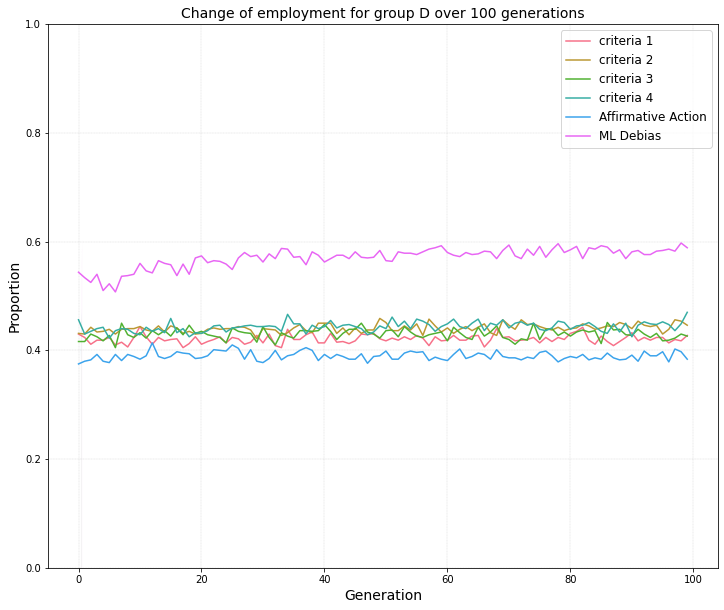

In [40]:

# plotting the graphs of our simulations. 
colors = sns.color_palette('husl', n_colors=5)
alpha = 1
for i in range(4):
  mean = np.mean(frac_criterians_ev[i], axis=1).squeeze()
  sem = stats.sem(frac_criterians_ev[i], axis=1).squeeze()
  plt.plot(mean, label=f'criteria {i+1}',alpha = alpha)
  plt.fill_between(mean - sem, mean + sem, alpha=0.2)

mean = np.mean(frac_criterians_ev[4], axis=1).squeeze()
sem = stats.sem(frac_criterians_ev[4], axis=1).squeeze()
plt.plot(mean, label=f'Affirmative Action')
plt.fill_between(mean - sem, mean + sem, alpha=0.2)

mean = np.mean(frac_criterians_ev[5], axis=1).squeeze()
sem = stats.sem(frac_criterians_ev[5], axis=1).squeeze()
plt.plot(mean, label=f'ML Debias')
plt.fill_between(mean - sem, mean + sem, alpha=0.2)
  
plt.grid(color='gray', linestyle='--', linewidth=0.3, alpha=0.5)
plt.title("Change of employment for group D over 100 generations", fontsize=14)
plt.xlabel("Generation", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.legend(loc ="upper right",fontsize = 12)
plt.ylim([0,1])
plt.show()